Usamos o modelo de regressão de Machine learning (random forest regressor) para fazer previsões em uma serie de tempo.


In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [2]:
# Versões dos pacotes usados no notebook

%reload_ext watermark
%watermark -a "César S. Hooper/ Março 2022" --iversions
!python --version

Author: César S. Hooper/ Março 2022

matplotlib: 3.3.4
pandas    : 1.2.4
numpy     : 1.19.5
cv2       : 4.5.4-dev

Python 3.8.8


In [3]:
path = 'C:/Users/Cesar Hooper/Desktop/github/bolsa_chile/Doc_csv'
empresas = os.listdir(path)

for empresa in empresas:
    globals()[empresa[0:-4]] = pd.read_csv(path + '/' + empresa)
    globals()[empresa[0:-4]].rename(columns={'A�o':'year', 'año':'year', 'Año':'year', 'A�oS':'year'}, inplace=True)
    
BSANTANDER.rename(columns={'A�os':'year'}, inplace=True)
CHILE.rename(columns={'Unnamed: 2':'mes', 'Unnamed: 3':'year'}, inplace=True)

# eliminando valores outliers e media movil
ccu_parte = CCU.High[800:7000]
ccu_trans = ccu_parte - ccu_parte.rolling(window=50).mean()
ccu_trans = ccu_trans.dropna()

### Dados

Vamos separar os dados. Dados para fazer o treinamento e o teste de cada modelo de regressão, e os dados futuro, com os quais avaliaremos cada modelo.

In [26]:
# divisão dos dados treino e 
dados = np.array(ccu_trans[0:5000])
dados_fut = ccu_trans[5000::]

### DataFrames

Para fazer as regressões vamos gerar diferentes tipos de dataframes. Os três parámetros para construir os DF serão:

$d$ : dimensão do vetor. Número de compoentes

$k$ : step entre o dado atual e o seguinte

$m$ : previsão. O dado a ser previsto.

Consideremos nossa serie tempo como a seguinte: ($x_1$, $x_2$, $x_3$, ..., $x_N$). Como exemplo, vamos construir os vetores históricos com dimensão $d$=$4$, step $k$=$2$ e a previsão $m$=$3$

$$
vetor_1 : (x_1, x_3, x_5, x_7) \rightarrow x_{10}\\
vetor_2 : (x_2, x_4, x_6, x_8) \rightarrow x_{11}\\
vetor_3 : (x_3, x_5, x_7, x_9) \rightarrow x_{12}\\
vetor_4 : (x_4, x_6, x_8, x_{10}) \rightarrow x_{13}\\
...
$$

Em geral, os vetores serão construidos obedecendo a seguinte regra: 
$$
vetor_t : (x_t, x_{t+k}, x_{t+2k}, x_{t+3k}) \rightarrow x_{t+3k+m}
$$

A imagem mostra a construção dos vetores e do target, o dado para previsão.


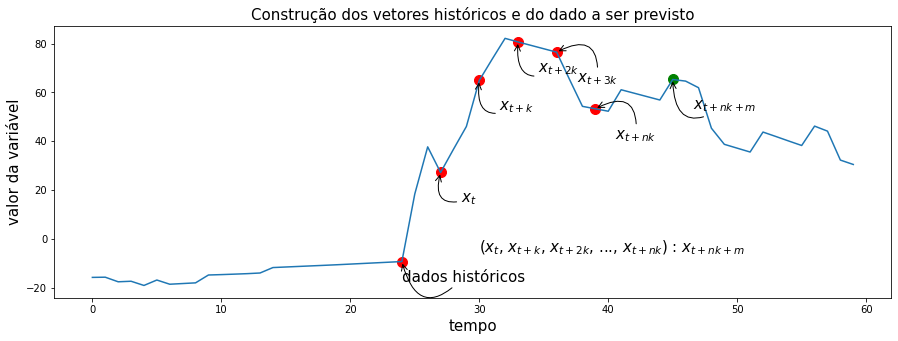

In [17]:
f = datos[40:100]
plt.figure(figsize=(15, 5))
plt.plot(f)
plt.title("Construção dos vetores históricos e do dado a ser previsto", fontsize=15)
plt.xlabel('tempo', fontsize=15)
plt.ylabel('valor da variável', fontsize=15)

plt.scatter([24],[f[24]], s=100, color='r')
plt.scatter([27],[f[27]], s=100, color='r')
plt.scatter([30],[f[30]], s=100, color='r')
plt.scatter([33], [f[33]],  s=100, color='r')
plt.scatter([36], [f[36]],  s=100, color='r')
plt.scatter([39], [f[39]],  s=100, color='r')
plt.scatter([45], [f[45]],  s=100, color='g')


plt.annotate('$x_t$',fontsize=15,xycoords='data',xy=(27,f[27]),
             textcoords='offset points',xytext=(20,-30),
             arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.9'))
plt.annotate('$x_{t+k}$',fontsize=15,xycoords='data',xy=(30,f[30]),
             textcoords='offset points',xytext=(20,-30),
             arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.9'))
plt.annotate('$x_{t+2k}$',fontsize=15,xycoords='data',xy=(33,f[33]),
             textcoords='offset points',xytext=(20,-30),
             arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.9'))
plt.annotate('$x_{t+3k}$',fontsize=15,xycoords='data',xy=(36,f[36]),
             textcoords='offset points',xytext=(20,-30),
             arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.9'))
plt.annotate('$x_{t+nk}$',fontsize=15,xycoords='data',xy=(39,f[39]),
             textcoords='offset points',xytext=(20,-30),
             arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.9'))

plt.annotate('$x_{t+nk+m}$',fontsize=15,xycoords='data',xy=(45,f[45]),
             textcoords='offset points',xytext=(20,-30),
             arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.9'))

plt.annotate('dados históricos',fontsize=15,xycoords='data',xy=(24,f[24]),
             textcoords='offset points',xytext=(0,-20),
             arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.9'))

plt.text(30,0, "($x_t$, $x_{t+k}$, $x_{t+2k}$, ..., $x_{t+nk}$) : $x_{t+nk+m}$",
         fontdict={'size':15,'color':'black'}, va='top')
plt.show()

Assim, o dataframe vai conter em cada fila um vetor histórico e o alvo u target. 

No apêndice está o algoritmo da função $criar_-dataset(dados, dim, step, previsão)$ com alguns detalhes.

Por enquanto, vamos a criar os datasets e os modelos de machine learning para fazer as regressões e estudar os resultados e as métricas.

Mas antes, vamos provar que a função funciona. A partir da nossa serie de tempo, vamos criar um dataset de dimansão 4, step 2 e previsão 3.

In [24]:
# Uma porção dos dados
datos[0:20]

array([-11.8 ,  -9.73,  -8.67,  -4.68,  -4.15,  -3.62,  -2.99,  -2.32,
        -1.69,  -0.57,   1.03,   1.53,   2.03,   2.47,   2.77,   3.07,
         2.97,   2.87,  13.51,  13.09])

In [22]:
# O dataset
dataset = cria_dataset(datos, 4, 2, 3)
dataset.head(5)

,x0,x1,x2,x3,target
0,-11.80,-8.67,-4.15,-2.99,-0.57
1,-9.73,-4.68,-3.62,-2.32,1.03
2,-8.67,-4.15,-2.99,-1.69,1.53
3,-4.68,-3.62,-2.32,-0.57,2.03
4,-4.15,-2.99,-1.69,1.03,2.47


### Regressões

Vamos criar o primeiro modelo de regressão, com um dataset com vetores de dimensão 1, step 1 e previsão 1.

In [27]:
# dataset dim=7, step=1, prev=1
dataset = cria_dataset(dados, 7, 1, 1)

In [28]:
dataset.head(5)

,x0,x1,x2,x3,x4,x5,x6,target
0,-11.80,-9.73,-8.67,-4.68,-4.15,-3.62,-2.99,-2.32
1,-9.73,-8.67,-4.68,-4.15,-3.62,-2.99,-2.32,-1.69
2,-8.67,-4.68,-4.15,-3.62,-2.99,-2.32,-1.69,-0.57
3,-4.68,-4.15,-3.62,-2.99,-2.32,-1.69,-0.57,1.03
4,-4.15,-3.62,-2.99,-2.32,-1.69,-0.57,1.03,1.53


In [29]:
y = dataset['target']
X = dataset.drop('target', axis=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

#  escalar os los dados
scaler = StandardScaler()
scaler.fit(X_train)

X_train_tf = scaler.transform(X_train)
X_test_tf = scaler.transform(X_test)

# aplicação do modelo
rfr = RandomForestRegressor(n_estimators=1000, max_depth=50)
rfr.fit(X_train_tf, y_train)

y_train_pred= rfr.predict(X_train_tf)
y_test_pred = rfr.predict(X_test_tf)

Text(0.5, 0, 'Tempo')

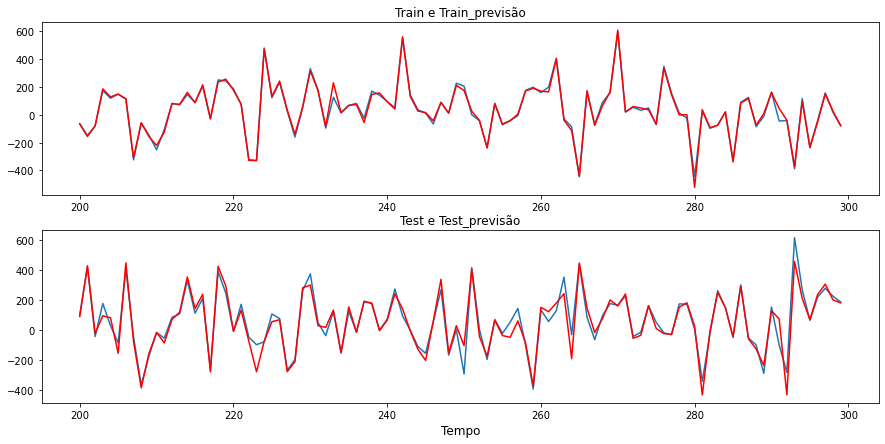

In [41]:
# plots

q1 = np.arange(0,len(y_train_pred))
q2 = np.arange(0,len(y_test_pred))
plt.figure(figsize=(15,7))
plt.subplot(2, 1, 1)
plt.plot(q1[200:300] , y_train[200:300])
plt.plot(q1[200:300], y_train_pred[200:300], 'r')
plt.title('Train e Train_previsão')

plt.subplot(2,1,2)
plt.plot(q2[200:300], y_test[200:300])
plt.plot(q2[200:300], y_test_pred[200:300], 'r')
plt.title('Test e Test_previsão')
plt.xlabel('Tempo', fontsize=12)

In [33]:
mae = mean_absolute_error(y_test_pred, y_test)
mse = mean_squared_error(y_test_pred, y_test)
rmse = np.sqrt(mse)
mae, mse, rmse

(32.33020641762202, 2811.3226021378377, 53.021906813484534)

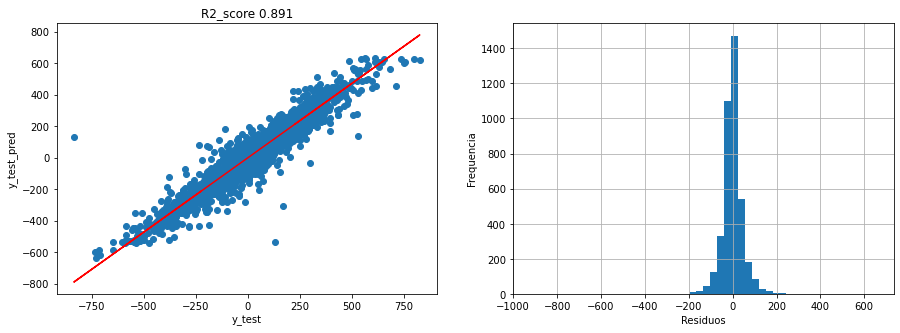

In [54]:
r2, yest = least_squared(y_test, y_test_pred)

Vamos fazer um loop para um dataset de dimensões 14, step 1, mas vamos variar os dias de previsõa entre 1 e 7.

Epoc: 1
Epoc: 2
Epoc: 3
Epoc: 4
Epoc: 5
Epoc: 6
Epoc: 7
Wall time: 0 ns
Wall time: 8min 53s


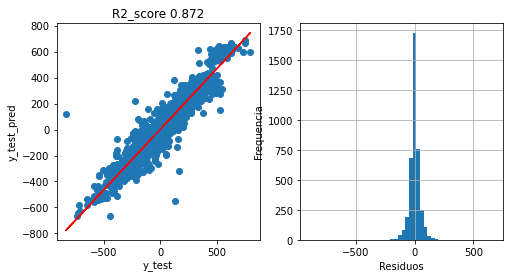

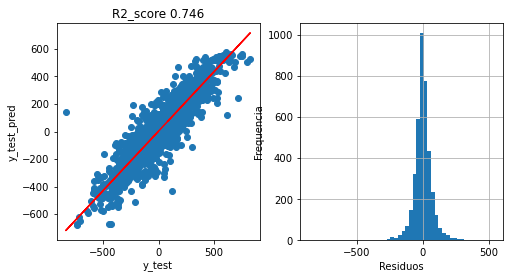

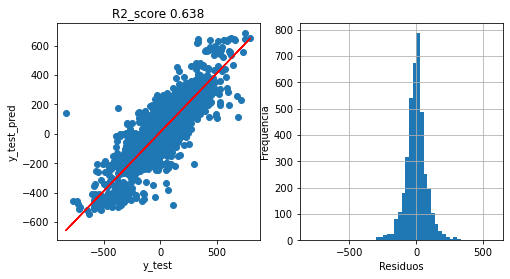

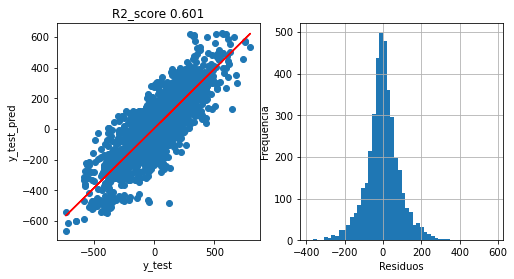

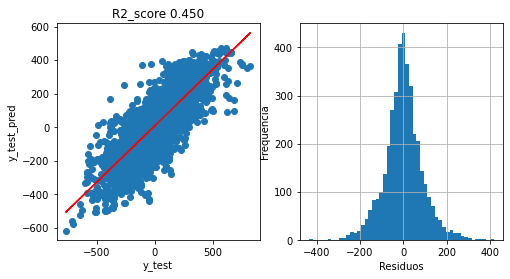

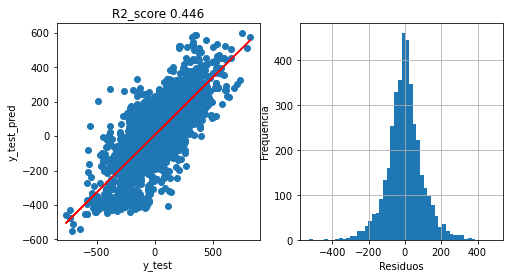

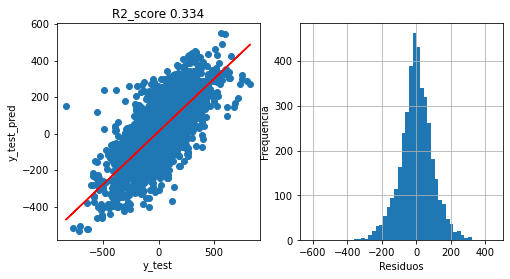

In [127]:
%%time
R2_score = pd.DataFrame()

dia = []
R2 = []
mae = []
rmse = []
c_var = []

for k in range(1, 8):
    
    dia.append(k)
    
    # cria o dataset
    dataset = cria_dataset(dados, 14, 1, k)
    
    y = dataset['target']
    X = dataset.drop('target', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

    #  escalar os los dados
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_tf = scaler.transform(X_train)
    X_test_tf = scaler.transform(X_test)

    # aplicação do modelo
    rfr = RandomForestRegressor(n_estimators=1000, max_depth=50)
    rfr.fit(X_train_tf, y_train)

    y_train_pred= rfr.predict(X_train_tf)
    y_test_pred = rfr.predict(X_test_tf)
    
    # metricas
    r2, _ = least_squared(y_test, y_test_pred)
    mae.append(mean_absolute_error(y_test_pred, y_test))
    mse = mean_squared_error(y_test_pred, y_test)
    rmse.append(np.sqrt(mse))
    # mae, mse, rmse
    R2.append(r2)
   
    print('Epoc: %.f'%k)
%time

R2_score['dia_prev'] = dia
R2_score['R2'] = r2
R2_score['c_rmse'] = rmse
R2_score['mae'] = mae

<Figure size 720x360 with 0 Axes>

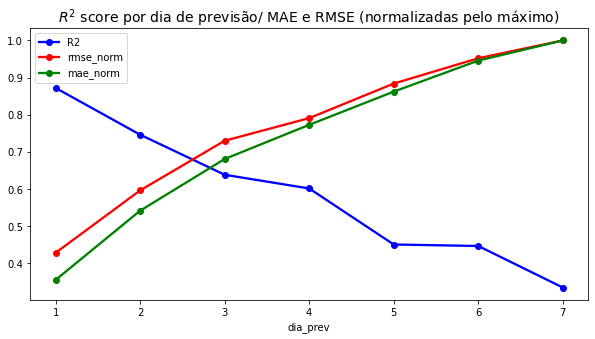

In [178]:
r2 = [0.872, 0.746, 0.638, 0.601, 0.450, 0.446, 0.334]
R2_score['R2'] = r2
R2_score['rmse_norm'] = R2_score['c_rmse']/R2_score['c_rmse'].max()
R2_score['mae_norm'] = R2_score['mae']/R2_score['mae'].max()

R2_score_reduc = R2_score[['dia_prev','R2', 'rmse_norm', 'mae_norm']].set_index('dia_prev')

# plots
cores = ['blue', 'red', 'green']
plt.figure(figsize=(10, 5))
R2_score_reduc.plot(color=cores, linewidth=2.3, figsize=(10, 5), style='-o')
plt.title('$R^2$ score por dia de previsão/ MAE e RMSE (normalizadas pelo máximo)', fontsize=14)

plt.show()

Finalmente, vamos fazer um vetor de dimensão 30 mas com step 3 para fazer previsões de 3, 6 e 9 dias.

Epoc: 3
Epoc: 6
Epoc: 9
Wall time: 0 ns
Wall time: 5min 43s


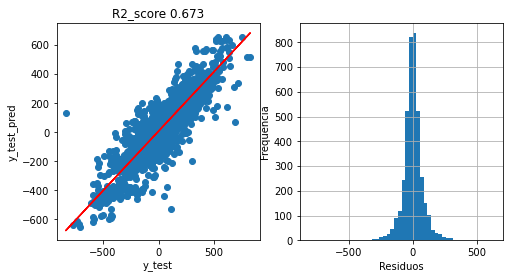

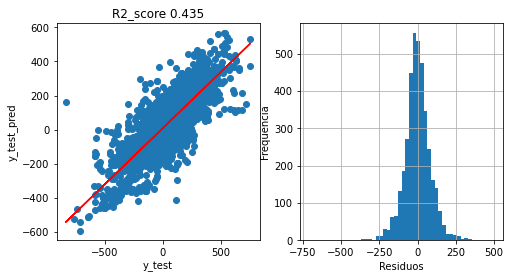

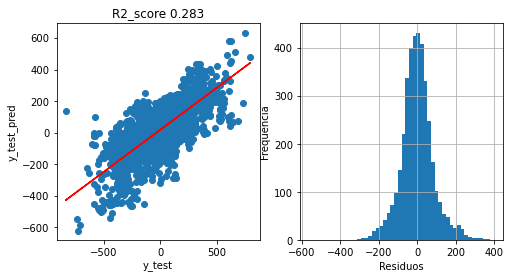

In [180]:
%%time
R2_score = pd.DataFrame()

dia = []
R2 = []
mae = []
rmse = []
c_var = []

for k in range(3, 10, 3):
    
    dia.append(k)
    
    # cria o dataset
    dataset = cria_dataset(dados, 30, 3, k)
    
    y = dataset['target']
    X = dataset.drop('target', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

    #  escalar os los dados
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_tf = scaler.transform(X_train)
    X_test_tf = scaler.transform(X_test)

    # aplicação do modelo
    rfr = RandomForestRegressor(n_estimators=1000, max_depth=50)
    rfr.fit(X_train_tf, y_train)

    y_train_pred= rfr.predict(X_train_tf)
    y_test_pred = rfr.predict(X_test_tf)
    
    # metricas
    r2, _ = least_squared(y_test, y_test_pred)
    mae.append(mean_absolute_error(y_test_pred, y_test))
    mse = mean_squared_error(y_test_pred, y_test)
    rmse.append(np.sqrt(mse))
    # mae, mse, rmse
    R2.append(r2)
   
    print('Epoc: %.f'%k)
%time

R2_score['dia_prev'] = dia
R2_score['R2'] = r2
R2_score['c_rmse'] = rmse
R2_score['mae'] = mae

<Figure size 720x360 with 0 Axes>

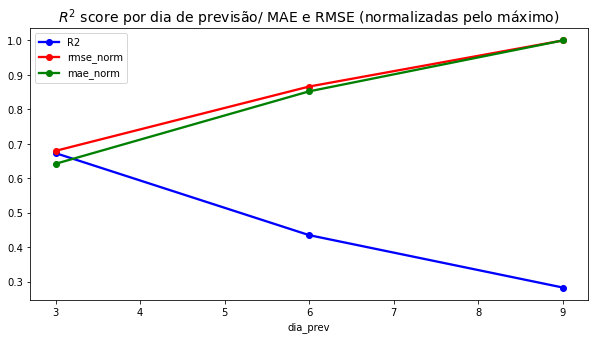

In [183]:
r2 = [0.673, 0.435, 0.283]
R2_score['R2'] = r2
R2_score['rmse_norm'] = R2_score['c_rmse']/R2_score['c_rmse'].max()
R2_score['mae_norm'] = R2_score['mae']/R2_score['mae'].max()

R2_score_reduc = R2_score[['dia_prev','R2', 'rmse_norm', 'mae_norm']].set_index('dia_prev')

# plots
cores = ['blue', 'red', 'green']
plt.figure(figsize=(10, 5))
R2_score_reduc.plot(color=cores, linewidth=2.3, figsize=(10, 5), style='-o')
plt.title('$R^2$ score por dia de previsão/ MAE e RMSE (normalizadas pelo máximo)', fontsize=14)

plt.show()

### Discusão

Até agora fizemos previsões com vetores construidos arbitrariamente. Mas na teoría de séries de tempo existe há muito tempo ferramentas que ajudan a construir os vetores históricos usando criterios matemáticos que, naturalmente, ajudam e melhoram a performance dos modelos de regressão de Machine Learning.

Fica pendente para outro Notebook fazer o estudio das previsões usando esses criterios matemáticos. 

## Apêndice

In [19]:
def cria_dataset(dados, dim, step, pred):
    
    """
    Cria dataset a partir de uma serie de tempo ---
    
    -- dados: serie de tempo
    -- dim: dimensão do vector
    -- step: intercalado para seleção dos dados
    -- pred: dia target para prever
    -- return: retorna dataframe com vetores e target
    """
   
    N = len(dados)
    
    if ((dim-1)*step+pred)>N: print('Problemas com Dimensões dos objetos')
    
    dataset = pd.DataFrame(columns=['x'+str(u) for u in range(dim)])
    targets = []
    
    k = 0
    while True:
        
        if (k + (dim-1)*step + pred) == N: break 
        else:             
            dataset.loc[k] = [dados[u] for u in range(k, k + (dim-1)*step + 1, step)]
            targets.append(dados[k + (dim-1)*step + pred])
            k += 1    
    
    dataset['target'] = targets
    
    return dataset
        

In [126]:
def least_squared(datox, datoy):
    
    # retorna R2 score y gráfico futuro vs prediccion
    
    # datox: es el dato original futuro
    # datoy: es la prediccion del futuro
           
    promx = datox.mean()
    promy = datoy.mean()

    a = sum(datox*(datoy - promy))/sum(datox*(datox - promx))
    b = promy - a*promx
    
    # la mejor funcion teorica
    y_est = a*datox + b
    
    R2 = sum((y_est - promy)**2)/sum((datox - promy)**2)
    e = pd.Series(y_est - datoy)
    #err_var = e.std()/len(e) # coeficiente de variacion
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(datox, datoy)
    plt.xlabel('y_test')
    plt.ylabel('y_test_pred')
    plt.title('R2_score %.3f'%R2)
    plt.plot(datox, y_est, 'r')
    plt.subplot(1, 2, 2)
    e.hist(bins=50)
    plt.xlabel('Residuos')
    plt.ylabel('Frequencia')

    return R2, y_est

# FIM